In [1]:
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]

In [3]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['energy_max'] = experiment_results['Ec'].apply(lambda E: np.max(E))
experiment_results['energy_norm'] = experiment_results['Ec'].apply(lambda E: np.linalg.norm(E))
experiment_results['energy_avg'] = experiment_results['Ec'].apply(lambda E: np.average(E))

max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['cost'].max().reset_index()
max_costs = max_costs.rename(columns={'cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['cost_rescaled'] = experiment_results['cost'] / experiment_results['max_cost']

In [4]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
]

## Comparison between optimizers (N = 15)

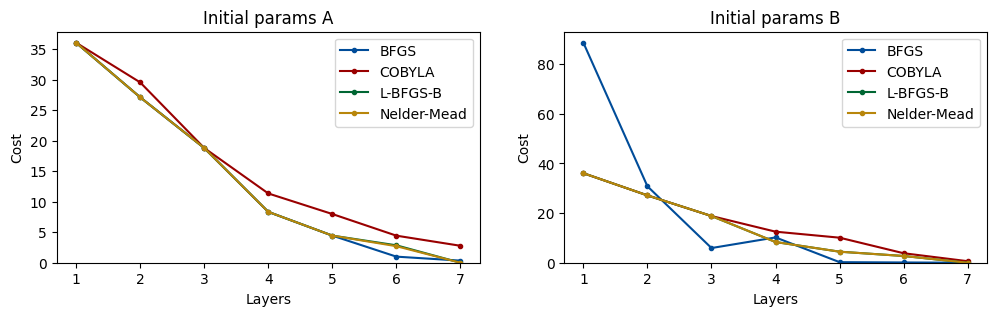

In [5]:
df = experiment_results[(experiment_results['N']==15) & (experiment_results['setup']=='standard')]
df = df.rename(columns={'optimizer_success': 'opt_succ'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

for j, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_opt = df[(df.optimizer == optimizer)]

    df_a = df_opt[df_opt['gamma_0'].round(5)==0.00557]
    axs[0].set_title('Initial params A')
    axs[0].plot('layers', 'cost', data=df_a, marker='.', color=plot_colors[j+1][0], label=optimizer)

    df_b = df_opt[df_opt['gamma_0'].round(5)==0.00058]
    axs[1].set_title('Initial params B')
    axs[1].plot('layers', 'cost', data=df_b, marker='.', color=plot_colors[j+1][0], label=optimizer)

for ax in axs:
    ax.set_ylabel('Cost')
    ax.set_xlabel('Layers')
    ax.set_ylim(0)
    ax.legend(loc='best')

* L-BFGS-B is the best overall optimizer among the tested methods.
* Nelder-Mead's performance is similar to L-BFGS-B, but it is in the limit of scalability.
* COBYLA has a good performance as long as a huge amount of steps are allowed, making it the
slowest of the tested methods. Even with that, the optimizer finds difficulties to succeed in
multiple occasions. It doesn't seem very appropriate for our problem.
* Since BFGS is unbounded, it is the least predictable method due to the QAOA periodic nature: $\exp (i \gamma H)$.
Interestingly, BFGS found better solutions than L-BFGS-B for some layers and converged to the problem's solution. It is sensitive to initial conditions.

## Standard protocol

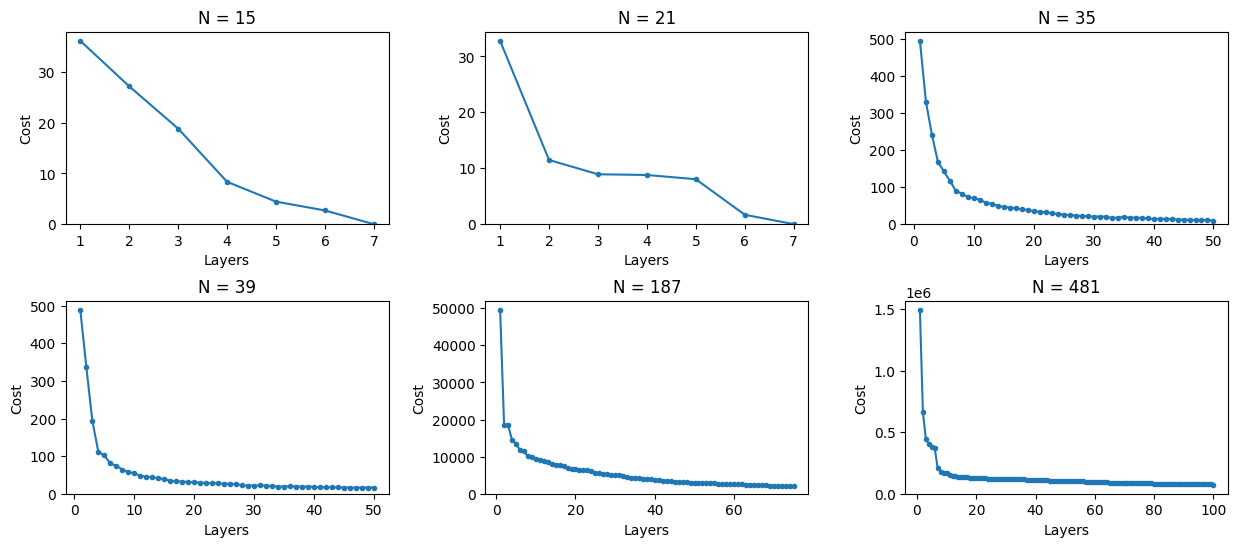

In [6]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())
setups = sorted(experiment_results['setup'].unique(), reverse=True)

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    axs[i].plot('layers', 'cost', data=df_N, marker='.')
    axs[i].set_ylabel('Cost')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

plt.savefig('../report_1/img/cost_layers.pdf')

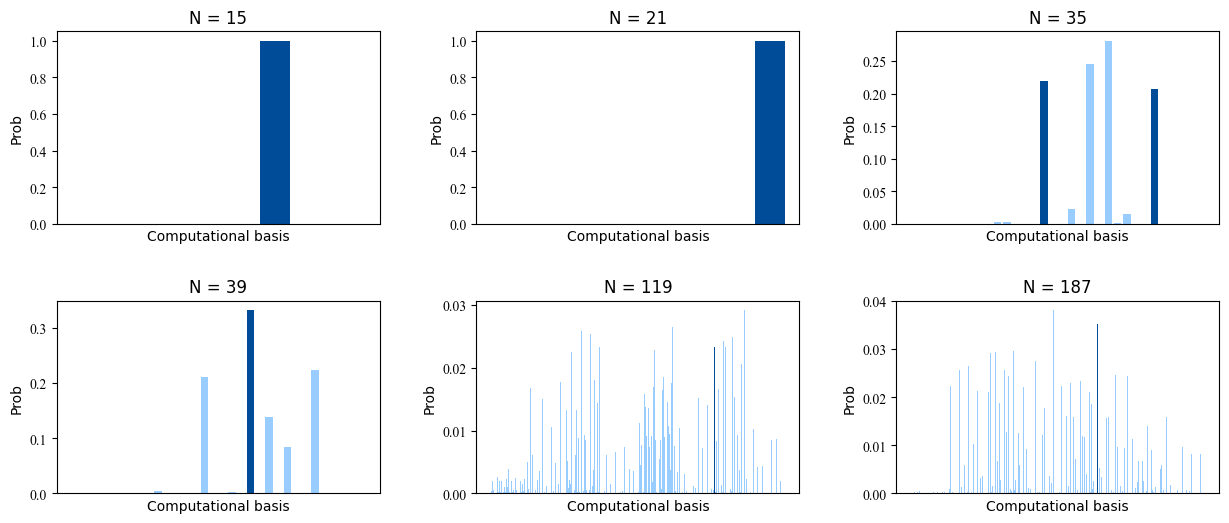

In [7]:
df = experiment_results[(experiment_results['setup']=='standard') & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']<=187)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    num_qubits = df_N.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_N.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

    axs[i].bar(x_hist, pops, color=bar_colors)
    axs[i].set_ylim(0)
    axs[i].set_ylabel('Prob')
    axs[i].set_xlabel('Computational basis')

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].set_xticks(range(2**num_qubits), "")
    axs[i].xaxis.set_major_locator(ticker.NullLocator())
    axs[i].set_title(f'N = {N}')

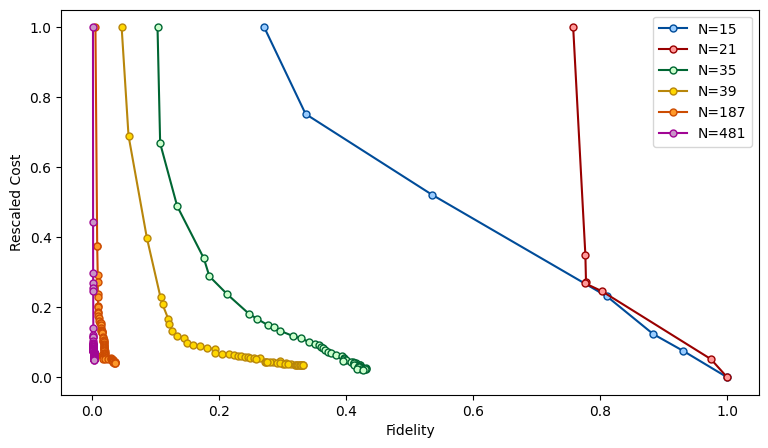

In [8]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

fig = plt.figure(figsize=(9,5))

for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    plt.plot(df_N['fidelity'], df_N['cost_rescaled'], label=f'N={N}',
             color=plot_colors[i+1][0], mec=plot_colors[i+1][0], mfc=plot_colors[i+1][1], marker='.',
             markersize=10)

plt.xlabel('Fidelity')
plt.ylabel('Rescaled Cost')
#plt.yscale('log')
plt.legend(loc='best')
#plt.show()

plt.savefig('../report_1/img/cost_fidelity.pdf')

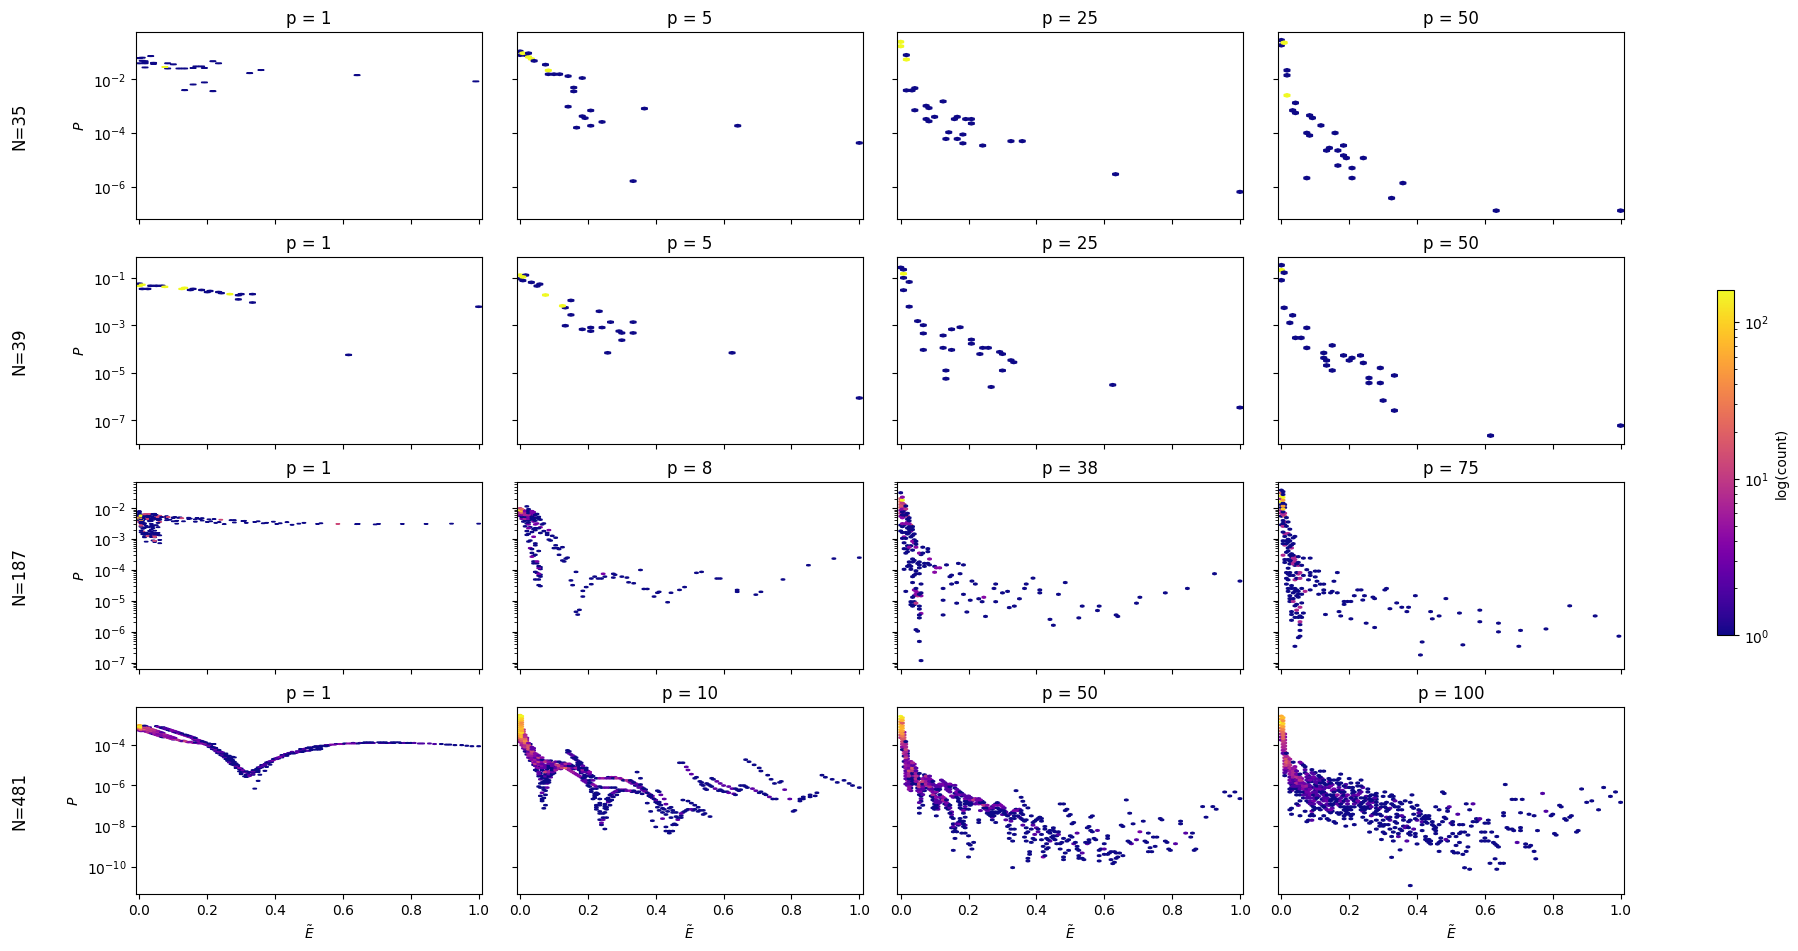

In [9]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']>=35)
                        & (experiment_results['N']!=119)]

Ns = sorted(df['N'].unique())

n_samples = 4
fig, axs = plt.subplots(nrows=len(Ns), ncols=n_samples, figsize=(24, len(Ns)*2.8),sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.1)

for idx_row, N in enumerate(Ns):
    df_N = df[(df['N']==N)]

    layer_max = df_N['layers'].max()
    n_samples = 4
    target_layers = [1, int(1+0.1*(layer_max-1)), int(1+0.5*(layer_max-1)), layer_max]
    
    for idx_col, p in enumerate(target_layers):
        
        df_p = df_N[df_N['layers']==p].copy()
        ax = axs[idx_row][idx_col]

        rescaled_energies_all = []
        probs_all = []

        for _, row in df_p.iterrows():
            probs = row['state_populations']
            energies = np.array(row['Ec'])

            E_min = np.min(energies)
            E_max = np.max(energies)
            rescaled_E = (energies - E_min) / (E_max - E_min)

            rescaled_energies_all.extend(rescaled_E)
            probs_all.extend(probs)

        # Plot using hexbin for density
        gridsize=60 if N < 187 else 100
        hb = ax.hexbin(rescaled_energies_all, probs_all,
                       gridsize=gridsize, cmap='plasma', bins='log', yscale='log')
                       
        ax.set_xlim(-0.01,1.01)
        
        ax.set_title(f'p = {p}', fontsize='large', fontweight='medium')
        if idx_col == 0:
            ax.set_ylabel('$P$')
        if idx_row == len(Ns)-1:
            ax.set_xlabel('$\\tilde{E}$')

        # Convert to NumPy arrays
        rescaled_energies_all = np.array(rescaled_energies_all)
        probs_all = np.array(probs_all)

        x = sorted(np.unique(rescaled_energies_all))
        y = []

        for e in x:
            idcs = np.where(rescaled_energies_all==e)
            probs = probs_all[idcs]
            y.append(np.average(probs))

        smoothed = lowess(y, x, frac=0.1)
        # ax.plot(smoothed[:,0], smoothed[:,1], color='green', linewidth=1)
        # ylim = 1e-6 if N < 187 else 1e-7
        # ax.set_ylim(ylim)

    # Get vertical center of any subplot in the row (e.g., first column)
    ax_row = axs[idx_row][0]
    pos = ax_row.get_position()
    y_center = (pos.y0 + pos.y1) / 2

    # Add label to the left of the row
    fig.text(0.08, y_center, f'N={N}', va='center', ha='right', fontsize='large', fontweight='medium', rotation=90)


# Color bar for density
fig.colorbar(hb, ax=axs, label='log(count)', shrink=0.4)

# plt.show()

plt.savefig('../report_1/img/prob_eigenstates.pdf')

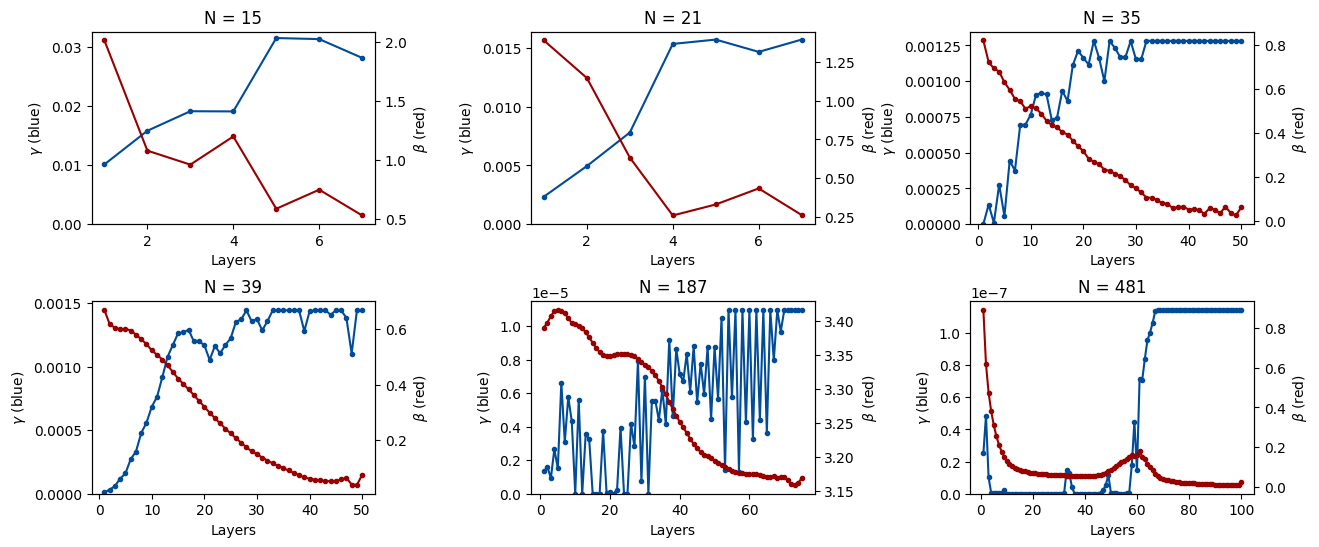

In [25]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.55)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    layers = df_N.loc[idx_last_layer, 'layers']
    gammas =  df_N.loc[idx_last_layer, 'gammas']
    betas = df_N.loc[idx_last_layer, 'betas']

    ax1 = axs[i]
    ax2 = ax1.twinx()

    ax1.plot(range(1,layers+1), gammas, marker='.', color=plot_colors[1][0])
    ax1.set_ylabel('$\\gamma$ (blue)')

    ax2.plot(range(1,layers+1), betas, marker='.', color=plot_colors[2][0])
    ax2.set_ylabel('$\\beta$ (red)')
    
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

plt.savefig('../report_1/img/angle_evolution.pdf')

### Comparing with an unbounded method (BFGS)

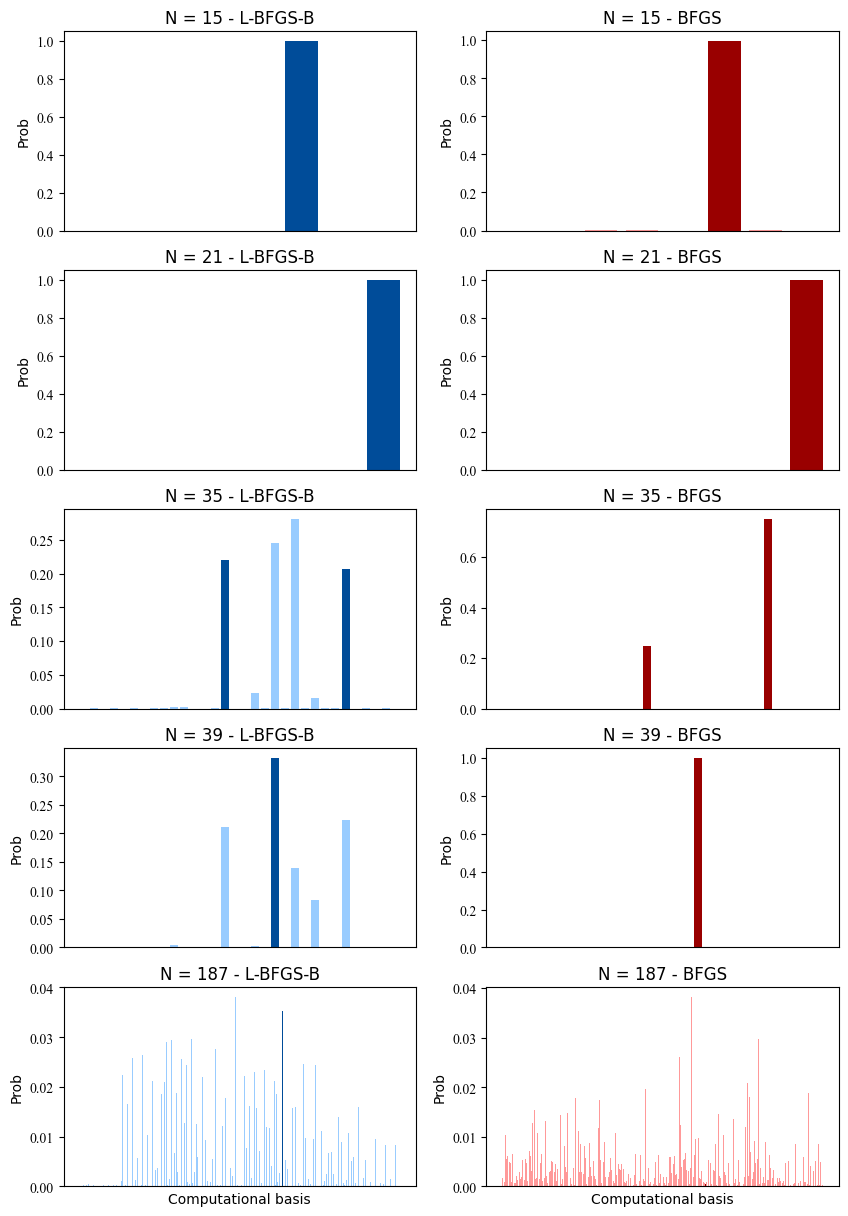

In [21]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['N']<=187)
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','optimizer','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

ncols = 2
nrows = len(Ns)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, N in enumerate(Ns):
    for j, optimizer in enumerate(['L-BFGS-B', 'BFGS']):
        df_N = df[(df['N']==N)&(df['optimizer']==optimizer)].reset_index()
        idx_last_layer = df_N['layers'].idxmax()
        num_qubits = df_N.loc[idx_last_layer, 'num_qubits']
        solutions = compute_solution(N)
        x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

        pops =  df_N.loc[idx_last_layer, 'state_populations']

        bar_colors = [plot_colors[j+1][0] if c in solutions else plot_colors[j+1][1] for c in x_hist]

        axs[i][j].bar(x_hist, pops, color=bar_colors)
        axs[i][j].set_ylim(0)
        axs[i][j].set_ylabel('Prob')

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].set_xticks(range(2**num_qubits), "")
        axs[i][j].xaxis.set_major_locator(ticker.NullLocator())
        axs[i][j].set_title(f'N = {N} - {optimizer}')

        if i == len(Ns)-1:
            axs[i][j].set_xlabel('Computational basis')

plt.savefig('../report_1/img/unbounded_populations.pdf')

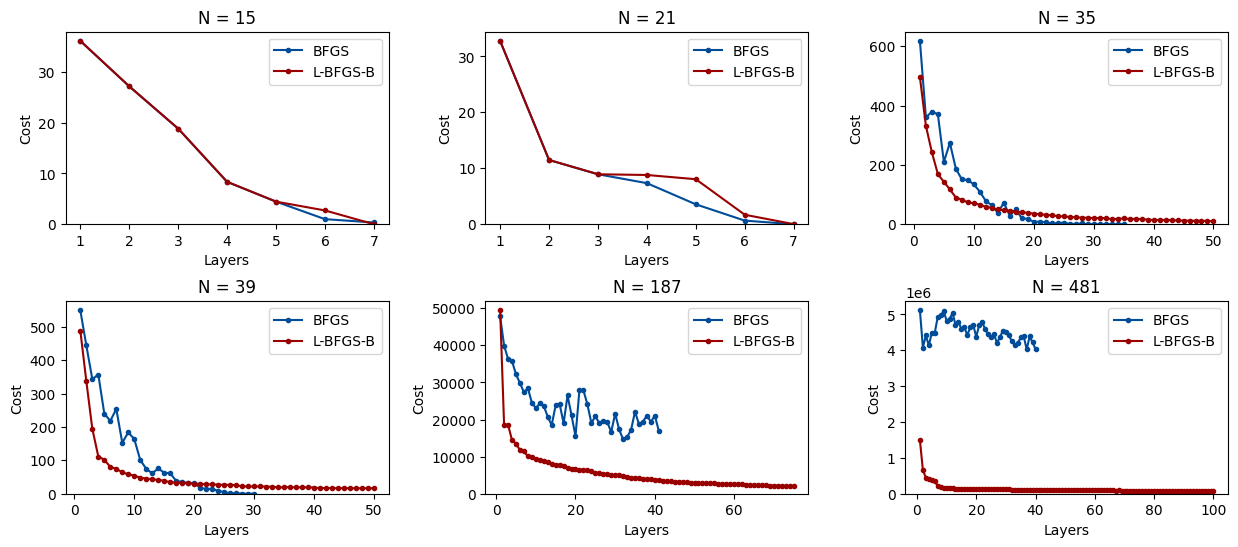

In [23]:
df = experiment_results[(experiment_results['setup']=='standard')&(experiment_results['N']!=119)]
df = df.groupby(['N','layers', 'optimizer']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = ['BFGS', 'L-BFGS-B']
setups = sorted(experiment_results['setup'].unique(), reverse=True)

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()
for i, N in enumerate(Ns):
    for j, optimizer in enumerate(optimizers):
        df_N = df[(df['N']==N) & (df['optimizer']==optimizer)]
        axs[i].plot('layers', 'cost', data=df_N, marker='.', label=optimizer, color=plot_colors[j+1][0])
    
    axs[i].set_ylabel('Cost')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')
    axs[i].legend(loc='best')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

plt.savefig('../report_1/img/unbounded_cost_evolution.pdf')

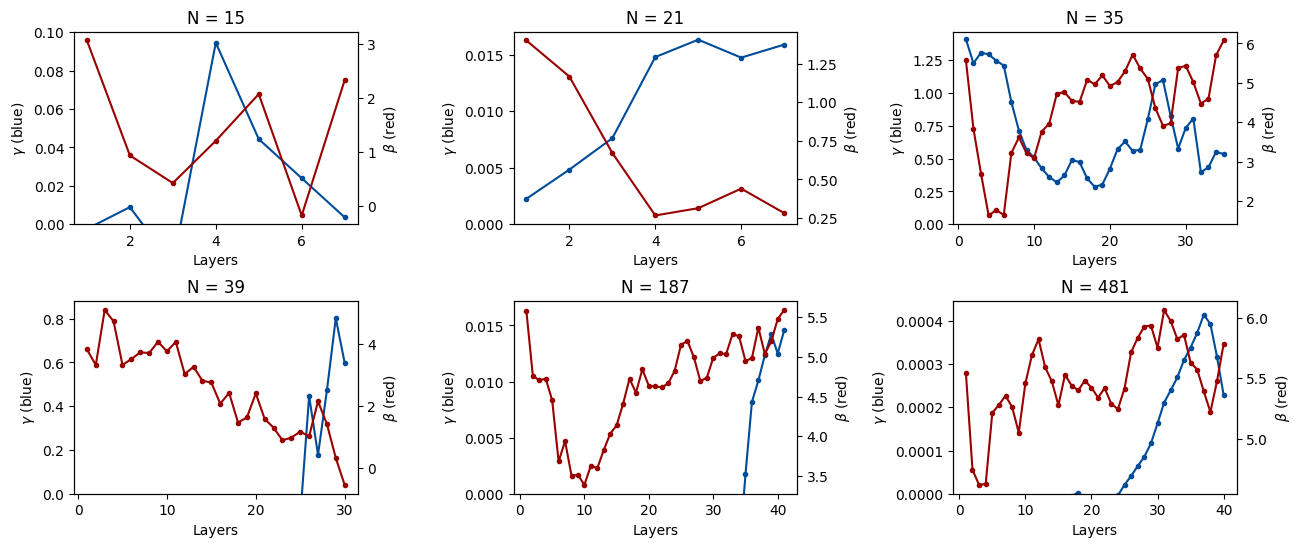

In [26]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='BFGS')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.55)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    layers = df_N.loc[idx_last_layer, 'layers']
    gammas =  df_N.loc[idx_last_layer, 'gammas']
    betas = df_N.loc[idx_last_layer, 'betas']

    ax1 = axs[i]
    ax2 = ax1.twinx()

    ax1.plot(range(1,layers+1), gammas, marker='.', color=plot_colors[1][0])
    ax1.set_ylabel('$\\gamma$ (blue)')

    ax2.plot(range(1,layers+1), betas, marker='.', color=plot_colors[2][0])
    ax2.set_ylabel('$\\beta$ (red)')
    
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

plt.savefig('../report_1/img/angle_evolution_unbounded.pdf')